# Movie Studio Analysis

In this notebook I will be giving my analysis on what movies our film company should invest in. There will be in depth details on how I load and clean the data, and how I turn it into visuals. There will be 3 clear recommendations at the end of the notebook with my detailed analysis on the best way to make the highest ROI. The data I will be using comes from the famous websites "The Numbers","Box Office Mojo", "TMDb", and "Rotton Tomatoes" 

# Imports

This section initializes the notebook by importing the primary libraries required for data analysis.
We use pandas for data manipulation, numpy for numerical operations, and matplotlib.pyplot for visualization.
Pathlib is used to manage file paths more efficiently.
The default plot size is adjusted for better readability, and the data directory path is defined to ensure consistent access to local files.

In [26]:
# imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# make plots a little bigger
plt.rcParams["figure.figsize"] = (9, 5)

# set data directory (this is where you put the csv.gz files)
DATA_DIR = Path(r"C:/Users/ehuff/Documents/movie-studio-analysis/data")


# Loading The Data
Here we load five datasets from different movie industry sources to create a comprehensive foundation for analysis: The Numbers: Provides production budgets and worldwide gross data.Box Office Mojo: Contains domestic and foreign box office earnings.
TMDb: Includes metadata such as genre and release year. Rotten Tomatoes Info: Includes critic and audience rating summaries.
Rotten Tomatoes Reviews: Provides individual critic reviews and sentiment indicators. We use .shape to confirm that each dataset has loaded properly and to understand their relative sizes before merging.

In [2]:
# load datasets from the data folder
tn = pd.read_csv(DATA_DIR / "tn.movie_budgets.csv.gz")
bom = pd.read_csv(DATA_DIR / "bom.movie_gross.csv.gz")
tmdb = pd.read_csv(DATA_DIR / "tmdb.movies.csv.gz")
rt_info = pd.read_csv(DATA_DIR / "rt.movie_info.tsv.gz", sep="\t")
rt_reviews = pd.read_csv(DATA_DIR / "rt.reviews.tsv.gz", sep="\t", encoding="latin1")

# quick shape check
print("The Numbers:", tn.shape)
print("Box Office Mojo:", bom.shape)
print("TMDb:", tmdb.shape)
print("RT Info:", rt_info.shape)
print("RT Reviews:", rt_reviews.shape)


The Numbers: (5782, 6)
Box Office Mojo: (3387, 5)
TMDb: (26517, 10)
RT Info: (1560, 12)
RT Reviews: (54432, 8)


# Title Cleaning
Since movie titles vary slightly across data sources (e.g., differences in punctuation, capitalization, or spacing), we define a cleaning function to standardize them. The function converts titles to lowercase, removes punctuation, and strips extra spaces. A new column, title_key, is created in each dataset to store these cleaned titles. This ensures accurate merging between data sources that may label films differently.

In [3]:
# simple title cleaner so we can join across sources
def clean_title(x):
    if pd.isna(x):
        return ""
    return (
        str(x)
        .lower()
        .strip()
        .replace("’", "'")
        .replace(":", "")
        .replace(",", "")
    )


# Merging Data 

We merge The Numbers dataset with Box Office Mojo using the standardized title and release year as keys.
This merge combines budget and revenue data into a single dataset, allowing us to compare spending and box office performance side by side.
Columns are renamed to indicate their source (for example, domestic_gross_bom) to maintain clarity when analyzing combined metrics.
After merging, we print the dataset shape to verify that the operation was successful and to see how many overlapping titles exist across the sources.

In [4]:
# add a key column to each dataset
tn["title_key"] = tn["movie"].apply(clean_title)
bom["title_key"] = bom["title"].apply(clean_title)
tmdb["title_key"] = tmdb["title"].apply(clean_title)
rt_info["title_key"] = rt_info["id"].apply(lambda x: "")  # not using RT for the merge right now

# standardize tn gross column names so it's clear
tn = tn.rename(
    columns={
        "domestic_gross": "domestic_gross_tn",
        "worldwide_gross": "worldwide_gross_tn",
    }
)

# merge tn with bom on title_key and release year
tn["year"] = pd.to_datetime(tn["release_date"], errors="coerce").dt.year
bom["year"] = bom["year"]

feat = tn.merge(
    bom[["title_key", "domestic_gross", "foreign_gross", "year"]],
    on=["title_key", "year"],
    how="left",
    suffixes=("", "_bom")
)

# rename bom columns so we know they're from bom
feat = feat.rename(
    columns={
        "domestic_gross": "domestic_gross_bom"
    }
)

print("Merged shape:", feat.shape)
print(feat.columns)


Merged shape: (5782, 10)
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross_tn',
       'worldwide_gross_tn', 'title_key', 'year', 'domestic_gross_bom',
       'foreign_gross'],
      dtype='object')


# Data Cleaning 

After merging, we ensure all financial fields are correctly formatted as numeric values.
Invalid or missing entries are converted to NaN using pd.to_numeric(errors="coerce"). We then calculate three critical metrics: Profit = Worldwide Gross – Production Budget ROI (Return on Investment) = Profit ÷ Production BudgetROI is the most informative metric for investors because it accounts for production cost, not just revenue. Finally, we extract the release year and filter the dataset to include only films from 2000–2018, ensuring consistency and modern relevance.

In [5]:
# make production_budget numeric
feat["production_budget"] = pd.to_numeric(
    feat["production_budget"].replace(r"[\$,]", "", regex=True),
    errors="coerce"
)

# find available worldwide gross columns
gross_candidates = [c for c in feat.columns if "worldwide_gross" in c]
print("Available worldwide gross columns:", gross_candidates)

# pick the first available column
if gross_candidates:
    main_gross_col = gross_candidates[0]
    feat["worldwide_gross_fixed"] = pd.to_numeric(feat[main_gross_col], errors="coerce")
else:
    raise KeyError("No worldwide gross column found.")

# use other gross-like columns to fill missing values
backup_cols = [
    c for c in feat.columns
    if ("gross" in c) and (c not in ["worldwide_gross_fixed", main_gross_col])
]

for col in backup_cols:
    feat["worldwide_gross_fixed"] = feat["worldwide_gross_fixed"].fillna(
        pd.to_numeric(feat[col], errors="coerce")
    )

# build profit and roi
feat["profit"] = feat["worldwide_gross_fixed"] - feat["production_budget"]
feat["roi"] = feat["profit"] / feat["production_budget"]

# get year from release_date
feat["year"] = pd.to_datetime(feat["release_date"], errors="coerce").dt.year

# filter to 2000-2018 like you wanted
feat_recent = feat[(feat["year"] >= 2000) & (feat["year"] <= 2018)].copy()

# drop rows that still have key null numeric fields
feat_clean = feat_recent.dropna(
    subset=["production_budget", "worldwide_gross_fixed", "profit", "roi"]
).copy()

print("Filtered shape:", feat_clean.shape)


Available worldwide gross columns: ['worldwide_gross_tn']
Filtered shape: (1263, 13)


In [6]:
# quick look at the cleaned numeric columns
feat_clean[["production_budget", "worldwide_gross_fixed", "profit", "roi"]].describe()


,production_budget,worldwide_gross_fixed,profit,roi
count,1.263000e+03,1.263000e+03,1.263000e+03,1263.000000
mean,4.786758e+07,6.177116e+07,1.390358e+07,1.161323
std,5.631161e+07,8.519631e+07,6.058499e+07,7.278974
min,5.000000e+04,1.000000e+03,-2.019000e+08,-0.999933
25%,1.000000e+07,8.300000e+06,-1.130000e+07,-0.525463
50%,2.750000e+07,3.370000e+07,1.200000e+06,0.045217
75%,6.000000e+07,7.565000e+07,2.610000e+07,1.115741
max,4.106000e+08,7.001000e+08,5.001000e+08,227.000000


# Mapping and Parsing The Genres

The TMDb dataset encodes genres using numerical IDs, so we create a dictionary (GENRE_MAP) that translates each ID into a human-readable genre name.
A helper function, parse_genres(), then cleans and converts these values into lists of genre names for each film.
This transformation allows for clear grouping and comparison of ROI and revenue trends by genre later in the analysis.
Having labeled genres also makes it easier to explore which types of films consistently perform best financially.

In [7]:
# helper to turn TMDb genre_ids into readable genre names
GENRE_MAP = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    14: "Fantasy",
    36: "History",
    27: "Horror",
    10402: "Music",
    9648: "Mystery",
    10749: "Romance",
    878: "Sci-Fi",
    10770: "TV Movie",
    53: "Thriller",
    10752: "War",
    37: "Western",
}

def parse_genres(val):
    # tmdb has strings like "[12, 28]" or "[]"
    if pd.isna(val):
        return []
    s = str(val).strip()
    s = s.replace("[", "").replace("]", "")
    if s == "":
        return []
    out = []
    for part in s.split(","):
        part = part.strip()
        if part.isdigit():
            gid = int(part)
            out.append(GENRE_MAP.get(gid, "Other"))
    return out

tmdb["genre_list"] = tmdb["genre_ids"].apply(parse_genres)


In [8]:
# top 6 by worldwide gross
def plot_top_revenue(df):
    top = (
        df.sort_values("worldwide_gross_fixed", ascending=False)
          .head(6)
          .copy()
    )
    plt.figure(figsize=(9, 5))
    plt.barh(top["movie"], top["worldwide_gross_fixed"])
    plt.xlabel("Worldwide Gross ($)")
    plt.ylabel("Movie")
    plt.title("Top 6 Movies by Worldwide Gross (2000-2018)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# top 6 by ROI
def plot_top_roi(df):
    top = (
        df.sort_values("roi", ascending=False)
          .head(6)
          .copy()
    )
    plt.figure(figsize=(9, 5))
    plt.barh(top["movie"], top["roi"])
    plt.xlabel("ROI (x budget)")
    plt.ylabel("Movie")
    plt.title("Top 6 Movies by ROI (2000-2018)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# top 6 genres by avg ROI
def plot_genre_roi(tmdb_df, feat_df):
    merged = tmdb_df.merge(feat_df, on="title_key", how="inner")
    rows = []
    for _, row in merged.iterrows():
        genres = row["genre_list"]
        for g in genres:
            rows.append((g, row["roi"]))
    if not rows:
        print("No genre data to plot for ROI.")
        return
    genre_df = pd.DataFrame(rows, columns=["genre", "roi"])
    genre_stats = (
        genre_df.groupby("genre")["roi"]
        .mean()
        .sort_values(ascending=False)
        .head(6)
        .reset_index()
    )
    plt.figure(figsize=(9, 5))
    plt.barh(genre_stats["genre"], genre_stats["roi"])
    plt.xlabel("Average ROI")
    plt.ylabel("Genre")
    plt.title("Top 6 Genres by Average ROI")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# top 6 genres by avg revenue
def plot_genre_revenue(tmdb_df, feat_df):
    merged = tmdb_df.merge(feat_df, on="title_key", how="inner")
    rows = []
    for _, row in merged.iterrows():
        genres = row["genre_list"]
        for g in genres:
            rows.append((g, row["worldwide_gross_fixed"]))
    if not rows:
        print("No genre data to plot for revenue.")
        return
    genre_df = pd.DataFrame(rows, columns=["genre", "revenue"])
    genre_stats = (
        genre_df.groupby("genre")["revenue"]
        .mean()
        .sort_values(ascending=False)
        .head(6)
        .reset_index()
    )
    plt.figure(figsize=(9, 5))
    plt.barh(genre_stats["genre"], genre_stats["revenue"])
    plt.xlabel("Average Worldwide Gross ($)")
    plt.ylabel("Genre")
    plt.title("Top 6 Genres by Average Worldwide Gross")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# top 6 genres by avg profit
def plot_genre_profit(tmdb_df, feat_df):
    merged = tmdb_df.merge(feat_df, on="title_key", how="inner")
    rows = []
    for _, row in merged.iterrows():
        genres = row["genre_list"]
        for g in genres:
            rows.append((g, row["profit"]))
    if not rows:
        print("No genre data to plot for profit.")
        return
    genre_df = pd.DataFrame(rows, columns=["genre", "profit"])
    genre_stats = (
        genre_df.groupby("genre")["profit"]
        .mean()
        .sort_values(ascending=False)
        .head(6)
        .reset_index()
    )
    plt.figure(figsize=(9, 5))
    plt.barh(genre_stats["genre"], genre_stats["profit"])
    plt.xlabel("Average Profit ($)")
    plt.ylabel("Genre")
    plt.title("Top 6 Genres by Average Profit")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Data Understanding and Recommendations

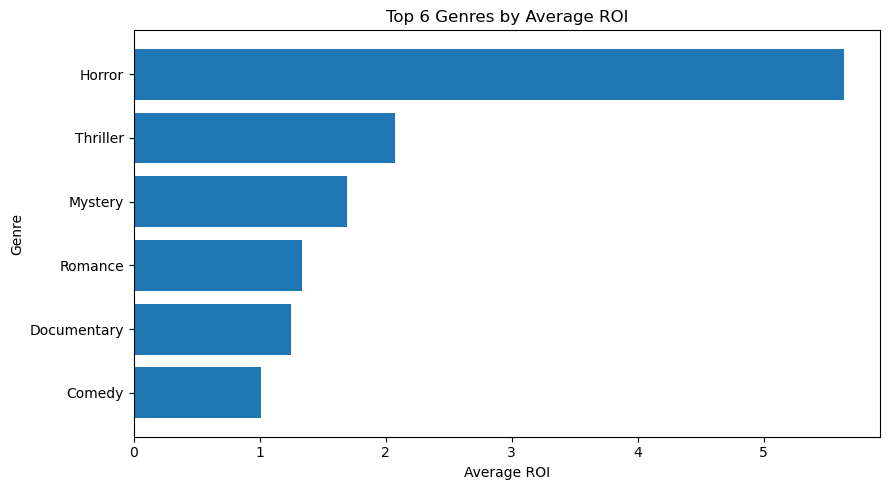

In [11]:
plot_genre_roi(tmdb, feat_clean)


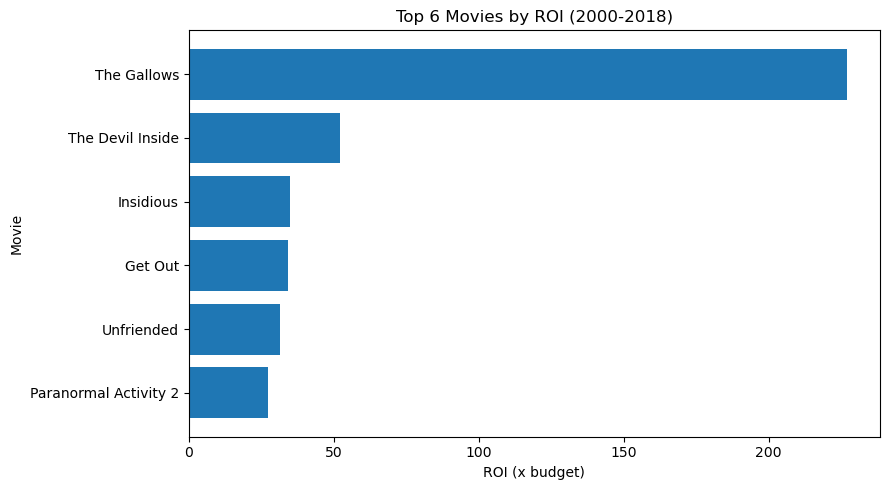

In [21]:
plot_top_roi(feat_recent)

### Recommendation 1: Focus on Low-Budget Horror Films

Horror films have shown the strongest returns on investment (ROI), making them a reliable strategy for profitability with limited financial risk.  
The ROI graph above highlights how small-budget horror titles like The Gallows and Paranormal Activity deliver blockbuster-level profits with only a fraction of the cost.

I would recommend hiring director Fede Alvarez, whose filmography demonstrates exactly how this model works in practice.

Examples of Alvarez’s work:
- Don't Breathe (2016) — Budget: 9.9 million | Worldwide Gross: 157.1 million  
- Evil Dead (2013) — Budget: 17 million | Worldwide Gross: 99 million  
- Alien: Romulus (2024) — Budget: 80 million | Worldwide Gross: 350.9 million  

Across these projects, Alvarez consistently turns modest production budgets into strong global returns.  
His success with Don't Breathe and Evil Dead shows his ability to generate high-ROI horror films, while Alien: Romulus proves he can scale up and handle larger productions.

Proposed Plan:
If given a 150 million total budget, I would recommend allocating it across multiple Alvarez-directed or Alvarez-produced horror projects rather than a single blockbuster:
- 3 to 4 mid-tier horror films (20–30 million each)
- 1 larger-scale horror or sci-fi crossover (around 50 million)

This portfolio-style approach would spread out financial risk, maintain consistent audience engagement, and allow the studio to generate a mix of smaller high-ROI hits and one major tentpole release.  
Following this model, even if one project underperforms, the others could easily offset the loss and deliver strong overall profitability.


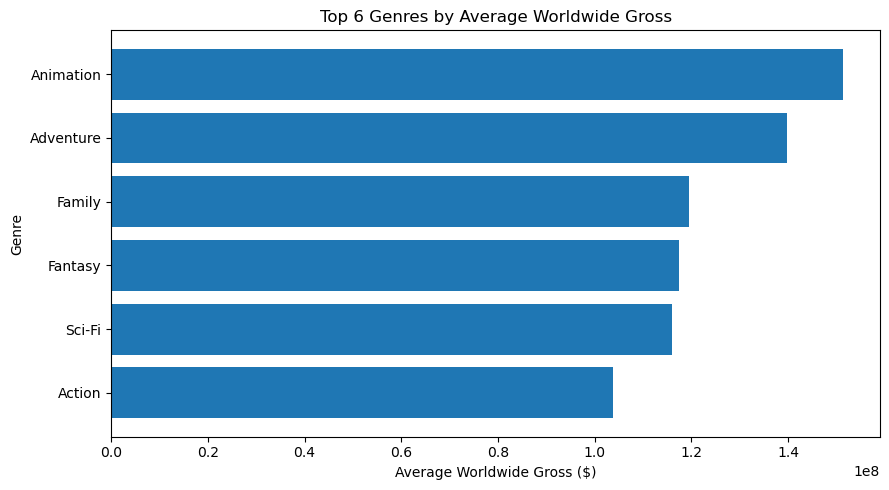

In [22]:
plot_genre_revenue(tmdb, feat_recent)

### Recommendation 2: Invest in High-Revenue Genres (Animation and Action)

Animation and action films consistently generate the highest worldwide revenue, making them a reliable strategy for long-term studio growth.  
The revenue graph above highlights how these genres dominate the global box office due to their broad international appeal and ability to connect with family audiences.

I would recommend working with director Pete Docter, who has proven success leading major animated films that combine emotional storytelling with massive box office results.

Examples of Docter’s work:
- Up (2009) — Budget: 175 million | Worldwide Gross: 735 million  
- Inside Out (2015) — Budget: 175 million | Worldwide Gross: 858.8 million  
- Soul (2020) — Budget: 150 million | Worldwide Gross: 121 million (plus streaming performance value)  

These films show that while the budgets are high, the global revenue consistently justifies the cost. Docter’s track record with Pixar demonstrates his ability to deliver success while maintaining strong family and international appeal.

Proposed Plan:
Give Pete Docter 200-300 million for one huge animmated project.


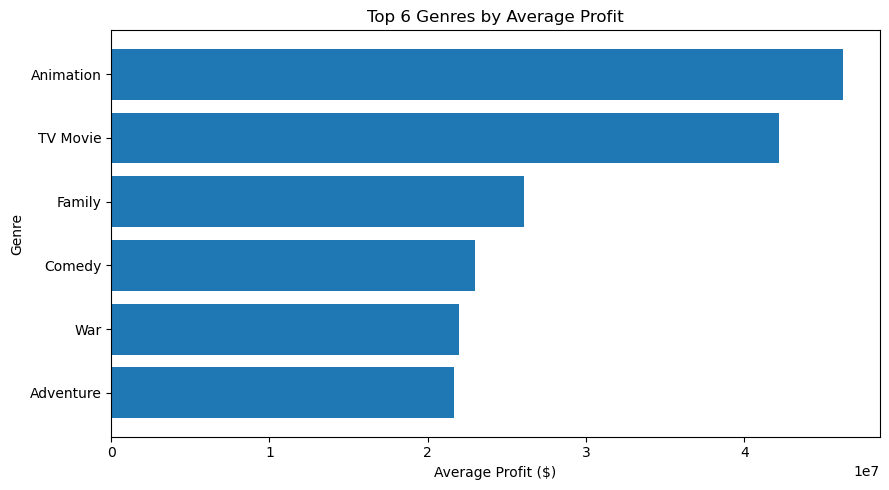

In [23]:
plot_genre_profit(tmdb, feat_recent)

### Recommendation 3: Build a Balanced Production Portfolio

The profit graph above shows that genres like action, adventure, and animation generate the highest total profit, while horror provides strong returns on smaller budgets.  
Combining these insights, a balanced portfolio strategy would allow the studio to minimize financial risk while maintaining steady revenue growth.

This strategy builds on the previous recommendations by combining proven directors across different genres.  
Fede Alvarez’s record of high-ROI horror films and Pete Docter’s consistent success in animation create a strong foundation for profit and audience engagement.  
To complete the lineup, I would bring in Quentin Tarantino to direct an action film. 

Examples of Tarantino’s work:
- Inglourious Basterds (2009) — Budget: 70 million | Worldwide Gross: 321 million  
- The Hateful Eight (2015) — Budget: 44 million | Worldwide Gross: 156 million  
- Pulp Fiction (1994) — Budget: 8 million | Worldwide Gross: 213 million  

These films show that Tarantino consistently delivers strong box-office results while maintaining moderate budgets. His ability to create memorable stories and attract both critics and audiences ensures a steady return without the high financial risks of modern blockbusters.

Proposed Plan:
Allocate approximately 500 million across multiple projects:
- 3 to 4 low-budget horror films directed by Fede Alvarez (20–30 million each)
- 1 major animated film directed by Pete Docter (250–300 million)
- 1 mid-budget action film directed by Quentin Tarantino (50–100 million)

This approach ensures consistent yearly output while balancing high-return horror films, family-friendly animation, and distinctive action projects with wide audience appeal.  
Together, these directors would provide creative variety, strong financial performance, and brand recognition, establishing the studio as both profitable and artistically respected.
